链式地址哈希表
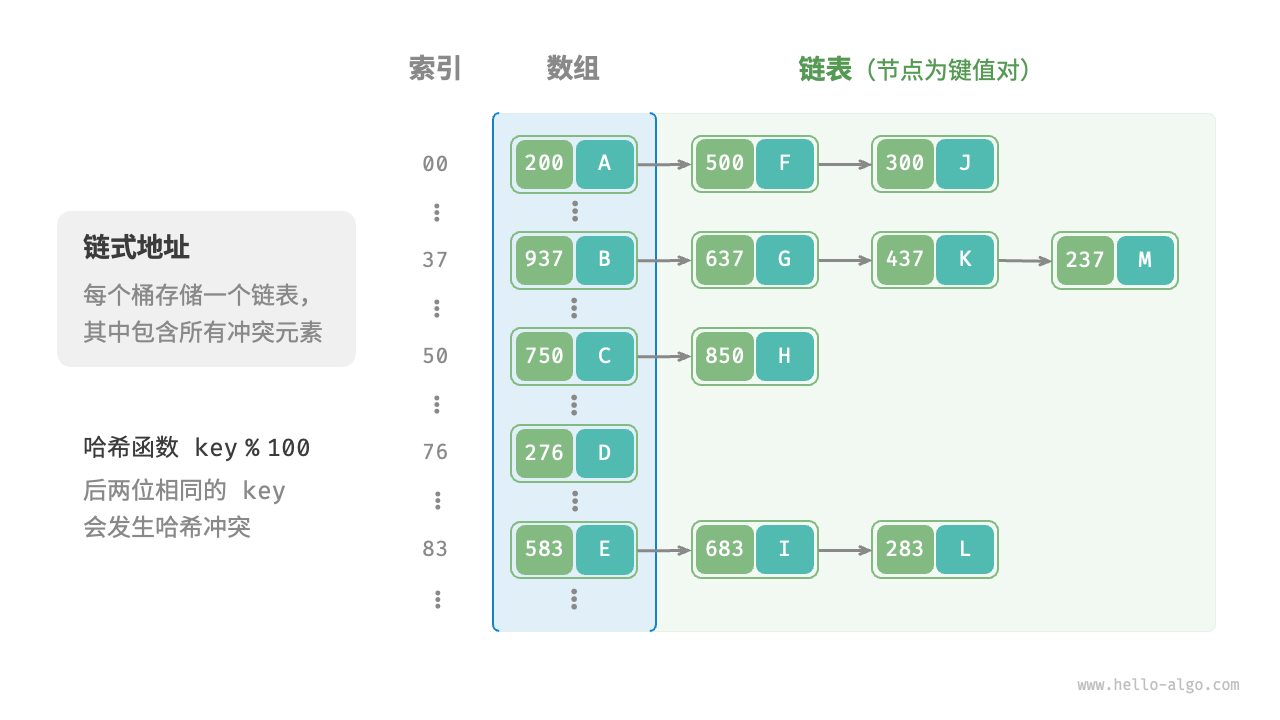

In [ ]:
class HashMapChaining:
    """链式地址哈希表"""

    def __init__(self):
        """构造方法"""
        self.size = 0  # 键值对数量
        self.capacity = 4  # 哈希表容量
        self.load_thres = 2.0 / 3.0  # 触发扩容的负载因子阈值
        self.extend_ratio = 2  # 扩容倍数
        self.buckets = [[] for _ in range(self.capacity)]  # 桶数组

    def hash_func(self, key: int) -> int:
        """哈希函数"""
        return key % self.capacity

    def load_factor(self) -> float:
        """负载因子"""
        return self.size / self.capacity

    def get(self, key: int) -> str | None:
        """查询操作"""
        index = self.hash_func(key)
        bucket = self.buckets[index]
        # 遍历桶，若找到 key ，则返回对应 val
        for pair in bucket:
            if pair.key == key:
                return pair.val
        # 若未找到 key ，则返回 None
        return None

    def put(self, key: int, val: str):
        """添加操作"""
        # 当负载因子超过阈值时，执行扩容
        if self.load_factor() > self.load_thres:
            self.extend()
        index = self.hash_func(key)
        bucket = self.buckets[index]
        # 遍历桶，若遇到指定 key ，则更新对应 val 并返回
        for pair in bucket:
            if pair.key == key:
                pair.val = val
                return
        # 若无该 key ，则将键值对添加至尾部
        pair = Pair(key, val)
        bucket.append(pair)
        self.size += 1

    def remove(self, key: int):
        """删除操作"""
        index = self.hash_func(key)
        bucket = self.buckets[index]
        # 遍历桶，从中删除键值对
        for pair in bucket:
            if pair.key == key:
                bucket.remove(pair)
                self.size -= 1
                break

    def extend(self):
        """扩容哈希表"""
        # 暂存原哈希表
        buckets = self.buckets
        # 初始化扩容后的新哈希表
        self.capacity *= self.extend_ratio
        self.buckets = [[] for _ in range(self.capacity)]
        self.size = 0
        # 将键值对从原哈希表搬运至新哈希表
        for bucket in buckets:
            for pair in bucket:
                self.put(pair.key, pair.val)

    def print(self):
        """打印哈希表"""
        for bucket in self.buckets:
            res = []
            for pair in bucket:
                res.append(str(pair.key) + " -> " + pair.val)
            print(res)

代码实现了一个包含懒删除的开放寻址（线性探测）哈希表。为了更加充分地使用哈希表的空间，我们将哈希表看作一个“环形数组”，当越过数组尾部时，回到头部继续遍历。
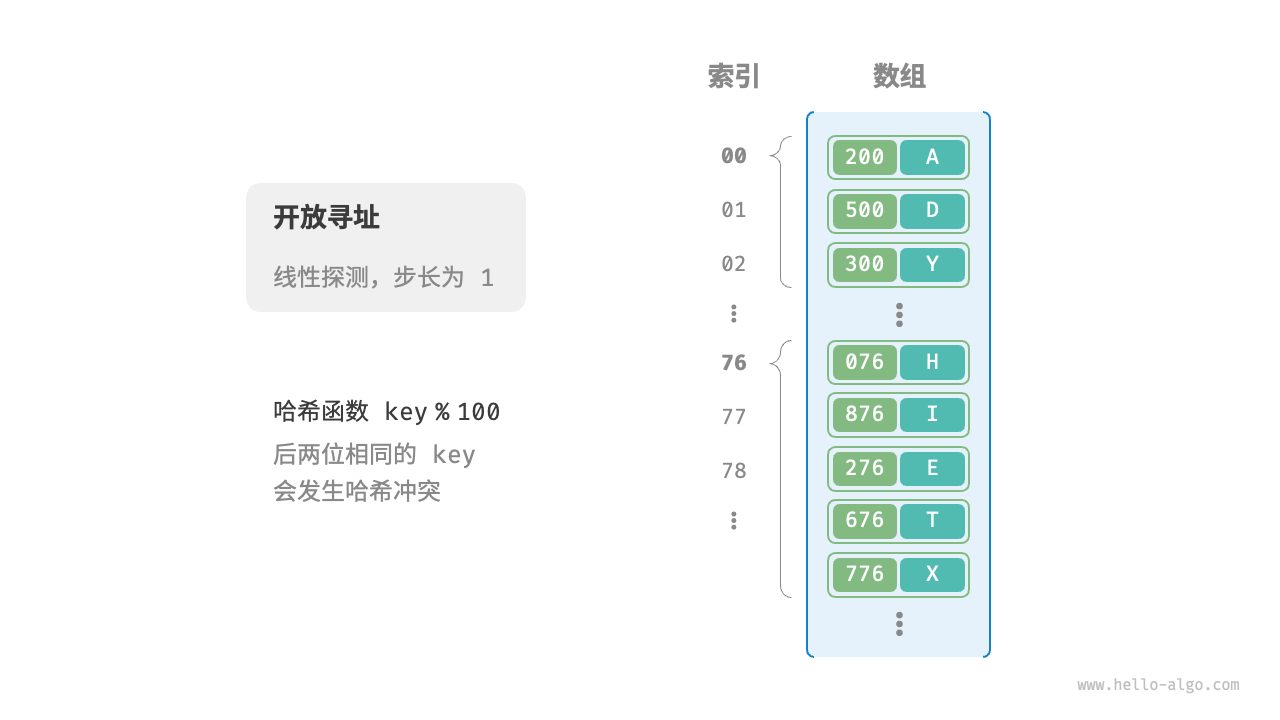

In [ ]:
class HashMapOpenAddressing:
    """开放寻址哈希表"""

    def __init__(self):
        """构造方法"""
        self.size = 0  # 键值对数量
        self.capacity = 4  # 哈希表容量
        self.load_thres = 2.0 / 3.0  # 触发扩容的负载因子阈值
        self.extend_ratio = 2  # 扩容倍数
        self.buckets: list[Pair | None] = [None] * self.capacity  # 桶数组
        self.TOMBSTONE = Pair(-1, "-1")  # 删除标记

    def hash_func(self, key: int) -> int:
        """哈希函数"""
        return key % self.capacity

    def load_factor(self) -> float:
        """负载因子"""
        return self.size / self.capacity

    def find_bucket(self, key: int) -> int:
        """搜索 key 对应的桶索引"""
        index = self.hash_func(key)
        first_tombstone = -1
        # 线性探测，当遇到空桶时跳出
        while self.buckets[index] is not None:
            # 若遇到 key ，返回对应的桶索引
            if self.buckets[index].key == key:
                # 若之前遇到了删除标记，则将键值对移动至该索引处
                if first_tombstone != -1:
                    self.buckets[first_tombstone] = self.buckets[index]
                    self.buckets[index] = self.TOMBSTONE
                    return first_tombstone  # 返回移动后的桶索引
                return index  # 返回桶索引
            # 记录遇到的首个删除标记
            if first_tombstone == -1 and self.buckets[index] is self.TOMBSTONE:
                first_tombstone = index
            # 计算桶索引，越过尾部则返回头部
            index = (index + 1) % self.capacity
        # 若 key 不存在，则返回添加点的索引
        return index if first_tombstone == -1 else first_tombstone

    def get(self, key: int) -> str:
        """查询操作"""
        # 搜索 key 对应的桶索引
        index = self.find_bucket(key)
        # 若找到键值对，则返回对应 val
        if self.buckets[index] not in [None, self.TOMBSTONE]:
            return self.buckets[index].val
        # 若键值对不存在，则返回 None
        return None

    def put(self, key: int, val: str):
        """添加操作"""
        # 当负载因子超过阈值时，执行扩容
        if self.load_factor() > self.load_thres:
            self.extend()
        # 搜索 key 对应的桶索引
        index = self.find_bucket(key)
        # 若找到键值对，则覆盖 val 并返回
        if self.buckets[index] not in [None, self.TOMBSTONE]:
            self.buckets[index].val = val
            return
        # 若键值对不存在，则添加该键值对
        self.buckets[index] = Pair(key, val)
        self.size += 1

    def remove(self, key: int):
        """删除操作"""
        # 搜索 key 对应的桶索引
        index = self.find_bucket(key)
        # 若找到键值对，则用删除标记覆盖它
        if self.buckets[index] not in [None, self.TOMBSTONE]:
            self.buckets[index] = self.TOMBSTONE
            self.size -= 1

    def extend(self):
        """扩容哈希表"""
        # 暂存原哈希表
        buckets_tmp = self.buckets
        # 初始化扩容后的新哈希表
        self.capacity *= self.extend_ratio
        self.buckets = [None] * self.capacity
        self.size = 0
        # 将键值对从原哈希表搬运至新哈希表
        for pair in buckets_tmp:
            if pair not in [None, self.TOMBSTONE]:
                self.put(pair.key, pair.val)

    def print(self):
        """打印哈希表"""
        for pair in self.buckets:
            if pair is None:
                print("None")
            elif pair is self.TOMBSTONE:
                print("TOMBSTONE")
            else:
                print(pair.key, "->", pair.val) 